In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nn_utils import (
    MapsDataset,
    Conv2Net,
    Conv1Net,
    MLPNet,
    ConvSimpleNet,
    train_validate,
    plot_train_val_loss,
    train_model,
    set_seed,
)

In [2]:
DIR = os.path.abspath("./dataset")
LABEL_MAPPER = {"Cars": 0, "Drones": 1, "People": 2}
INV_LABEL_MAPPER = {v: k for k, v in LABEL_MAPPER.items()}
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 0

# def get_data_for_label(label):
#     X, y = [], []
#     for root, dirs, files in os.walk(os.path.join(DIR, label)):
#         for file in files:
#             if file.endswith('.csv'):
#                 y.append(LABEL_MAPPER[label])
#                 df = pd.read_csv(os.path.join(root, file), sep=',', header=None)
#                 X.append(df.values)
#     print(f'Loaded {len(y)} examples for label {label} encoded with {LABEL_MAPPER[label]}')
#     return X, y

# X_cars, y_cars = get_data_for_label('Cars')
# X_drones, y_drones = get_data_for_label('Drones')
# X_people, y_people = get_data_for_label('People')

# X = X_cars + X_drones + X_people
# y = y_cars + y_drones + y_people
# X, y = np.array(X), np.array(y)

# %store X
# %store y

%store -r X
%store -r y

In [3]:
# Data normalization to normal distribution
def standard_normalizer(X):
    n_samples = X.shape[0]
    for sid in range(n_samples):
        matrix = X[sid, :, :]
        X[sid, :, :] = (matrix - np.mean(matrix)) / np.std(matrix)
    return X


X = standard_normalizer(X)
n_total = len(X)

# separating train, validation, test
test_size = 0.1
val_size = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=test_size, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=val_size / (1 - test_size),
    random_state=SEED,
    stratify=y_trainval,
)
train_dataset = MapsDataset(X_train, y_train)
val_dataset = MapsDataset(X_val, y_val)

print(f"Training: {len(X_train)} samples -> {len(X_train)/n_total*100:.2f} %")
print(f"Validation: {len(X_val)} samples -> {len(X_val)/n_total*100:.2f} %")
print(f"Test: {len(X_test)} samples -> {len(X_test)/n_total*100:.2f} %")

Training: 12239 samples -> 70.00 %
Validation: 3497 samples -> 20.00 %
Test: 1749 samples -> 10.00 %


In [9]:
# check that it overfit a small batch
# batch_size = 2
# num_epochs = 100
# lr = 1e-4
# train_dataset = MapsDataset(X_train[:batch_size], y_train[:batch_size])
# val_dataset = MapsDataset(X_val[:batch_size], y_val[:batch_size])
# train_loss, val_loss, train_acc, val_acc = train_model(train_dataset, val_dataset, batch_size, num_epochs, lr)

--- Epoch 1/25: 
Train      -> loss = 0.433 | acc = 0.857
Validation -> loss = 0.237 | acc = 0.919
--- Epoch 2/25: 
Train      -> loss = 0.218 | acc = 0.917
Validation -> loss = 0.225 | acc = 0.924
--- Epoch 3/25: 
Train      -> loss = 0.192 | acc = 0.927
Validation -> loss = 0.205 | acc = 0.931
--- Epoch 4/25: 
Train      -> loss = 0.172 | acc = 0.934
Validation -> loss = 0.209 | acc = 0.922
--- Epoch 5/25: 
Train      -> loss = 0.161 | acc = 0.938
Validation -> loss = 0.215 | acc = 0.920
--- Epoch 6/25: 
Train      -> loss = 0.153 | acc = 0.943
Validation -> loss = 0.202 | acc = 0.925
--- Epoch 7/25: 
Train      -> loss = 0.143 | acc = 0.947
Validation -> loss = 0.199 | acc = 0.930
--- Epoch 8/25: 
Train      -> loss = 0.137 | acc = 0.950
Validation -> loss = 0.199 | acc = 0.929
--- Epoch 9/25: 
Train      -> loss = 0.128 | acc = 0.955
Validation -> loss = 0.201 | acc = 0.932
--- Epoch 10/25: 
Train      -> loss = 0.120 | acc = 0.954
Validation -> loss = 0.198 | acc = 0.930
--- Epoch

c:\javier\personal_projects\ml\radar-doppler\nn_utils.py:241: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(np.arange(num_epochs), val_loss, "r-", color='royalblue', label="validation loss")
c:\javier\personal_projects\ml\radar-doppler\nn_utils.py:242: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(np.arange(num_epochs), val_acc, "r--", color='royalblue', label="validation acc")


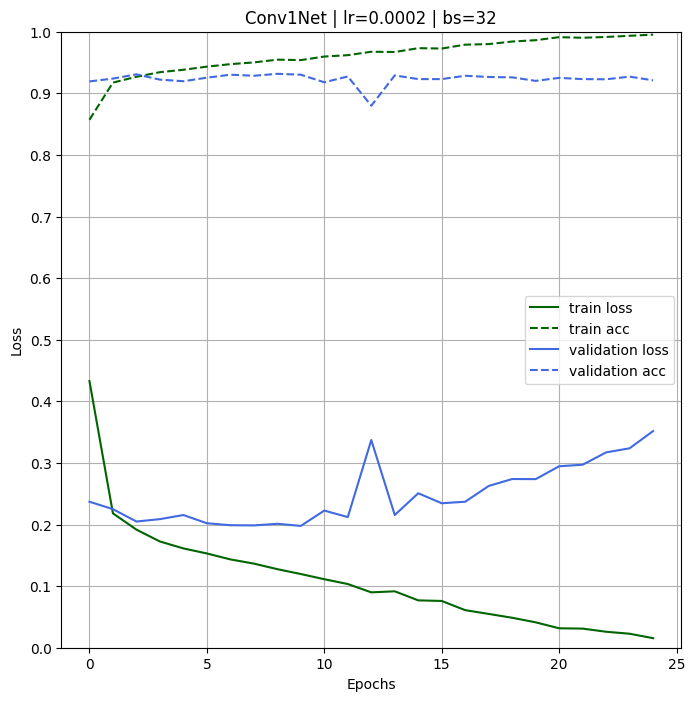

In [11]:
set_seed(SEED+3)
batch_size = 32
lr = 2e-4
num_epochs = 25
k1_size = (3, 3)
p_dropout = 0.
model = Conv1Net(k1_size)
train_loss, val_loss, train_acc, val_acc, model = train_model(
    model, train_dataset, val_dataset, batch_size, num_epochs, lr
)
fig = plot_train_val_loss(
    num_epochs,
    train_loss,
    train_acc,
    val_loss,
    val_acc,
    title=f"{type(model).__name__} | lr={lr} | bs={batch_size}",
)
plt.tight_layout()
fig.savefig('./figures/conv1_results.png')

In [6]:
from torchsummary import summary

summary(model, input_size=(1, 11, 61))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 20, 9, 59]             200
              ReLU-2            [-1, 20, 9, 59]               0
         MaxPool2d-3            [-1, 20, 4, 29]               0
            Linear-4                   [-1, 64]         148,544
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
              ReLU-7                   [-1, 64]               0
           Dropout-8                   [-1, 64]               0
            Linear-9                   [-1, 64]           4,160
             ReLU-10                   [-1, 64]               0
          Dropout-11                   [-1, 64]               0
           Linear-12                    [-1, 3]             195
             ReLU-13                    [-1, 3]               0
          Dropout-14                   

--- Epoch 1/25: 
Train      -> loss = 0.546 | acc = 0.801
Validation -> loss = 0.290 | acc = 0.899
--- Epoch 2/25: 
Train      -> loss = 0.253 | acc = 0.903
Validation -> loss = 0.233 | acc = 0.918
--- Epoch 3/25: 
Train      -> loss = 0.218 | acc = 0.916
Validation -> loss = 0.240 | acc = 0.914
--- Epoch 4/25: 
Train      -> loss = 0.203 | acc = 0.922
Validation -> loss = 0.201 | acc = 0.926
--- Epoch 5/25: 
Train      -> loss = 0.192 | acc = 0.927
Validation -> loss = 0.197 | acc = 0.930
--- Epoch 6/25: 
Train      -> loss = 0.182 | acc = 0.929
Validation -> loss = 0.198 | acc = 0.923
--- Epoch 7/25: 
Train      -> loss = 0.174 | acc = 0.935
Validation -> loss = 0.191 | acc = 0.932
--- Epoch 8/25: 
Train      -> loss = 0.164 | acc = 0.937
Validation -> loss = 0.208 | acc = 0.926
--- Epoch 9/25: 
Train      -> loss = 0.159 | acc = 0.938
Validation -> loss = 0.178 | acc = 0.935
--- Epoch 10/25: 
Train      -> loss = 0.153 | acc = 0.943
Validation -> loss = 0.171 | acc = 0.937
--- Epoch

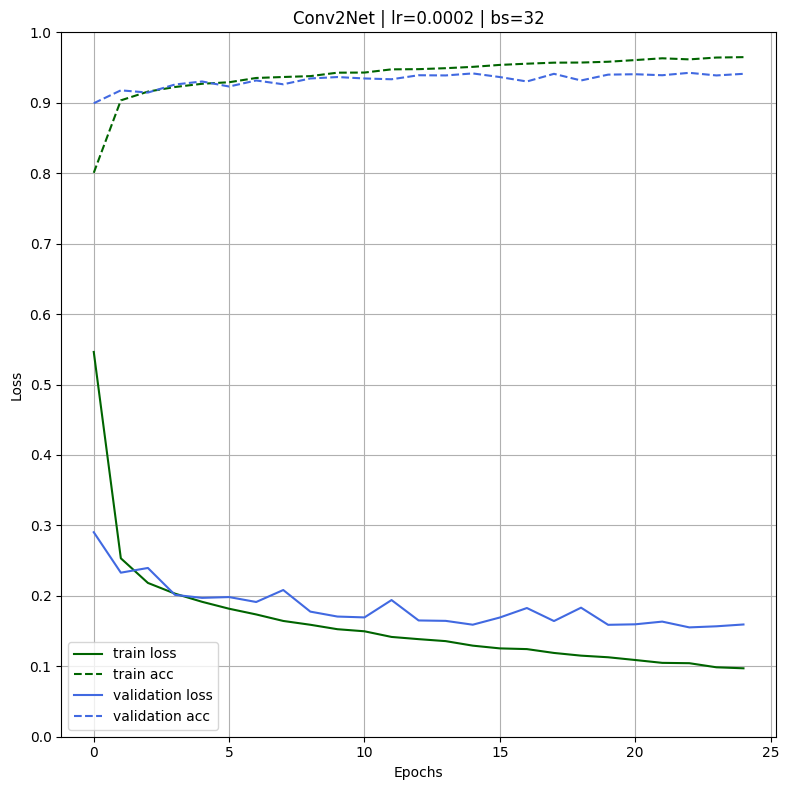

In [10]:
set_seed(SEED)
batch_size = 32
lr = 2e-4
num_epochs = 25
k1_size = (3, 3)
k2_size = (3, 3)
model = Conv2Net(k1_size, k2_size)
train_loss, val_loss, train_acc, val_acc, model = train_model(
    model, train_dataset, val_dataset, batch_size, num_epochs, lr
)
fig = plot_train_val_loss(
    num_epochs,
    train_loss,
    train_acc,
    val_loss,
    val_acc,
    title=f"{type(model).__name__} | lr={lr} | bs={batch_size}",
)
plt.tight_layout()
fig.savefig('./figures/conv_results.png')

In [11]:
summary(model, input_size=(1, 11, 61))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 10, 9, 59]             100
              ReLU-2            [-1, 10, 9, 59]               0
         MaxPool2d-3            [-1, 10, 4, 29]               0
            Conv2d-4            [-1, 20, 2, 27]           1,820
              ReLU-5            [-1, 20, 2, 27]               0
         MaxPool2d-6            [-1, 20, 1, 13]               0
            Linear-7                   [-1, 64]          16,704
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 64]           4,160
             ReLU-10                   [-1, 64]               0
           Linear-11                    [-1, 3]             195
Total params: 22,979
Trainable params: 22,979
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
# Check performance on test set

test_dataset = MapsDataset(X_test, y_test)
model.eval()
Xtr, ytr = torch.from_numpy(X_test).float().to(DEVICE), torch.from_numpy(y_test).type(torch.LongTensor).to(DEVICE)
y_pred = model(Xtr[None, :].permute(1, 0, 2, 3))
pred_labels = torch.argmax(y_pred, dim=1)
(torch.sum(pred_labels == ytr)).item()/len(ytr)

### Additional explorations

--- Epoch 1/100: 
Train      -> loss = 0.771 | acc = 0.634
Validation -> loss = 0.460 | acc = 0.839
--- Epoch 2/100: 
Train      -> loss = 0.354 | acc = 0.872
Validation -> loss = 0.296 | acc = 0.897
--- Epoch 3/100: 
Train      -> loss = 0.265 | acc = 0.905
Validation -> loss = 0.250 | acc = 0.911
--- Epoch 4/100: 
Train      -> loss = 0.231 | acc = 0.914
Validation -> loss = 0.228 | acc = 0.922
--- Epoch 5/100: 
Train      -> loss = 0.214 | acc = 0.921
Validation -> loss = 0.226 | acc = 0.921
--- Epoch 6/100: 
Train      -> loss = 0.209 | acc = 0.920
Validation -> loss = 0.215 | acc = 0.926
--- Epoch 7/100: 
Train      -> loss = 0.200 | acc = 0.922
Validation -> loss = 0.204 | acc = 0.930
--- Epoch 8/100: 
Train      -> loss = 0.190 | acc = 0.927
Validation -> loss = 0.201 | acc = 0.931
--- Epoch 9/100: 
Train      -> loss = 0.187 | acc = 0.930
Validation -> loss = 0.198 | acc = 0.930
--- Epoch 10/100: 
Train      -> loss = 0.181 | acc = 0.931
Validation -> loss = 0.192 | acc = 0.931

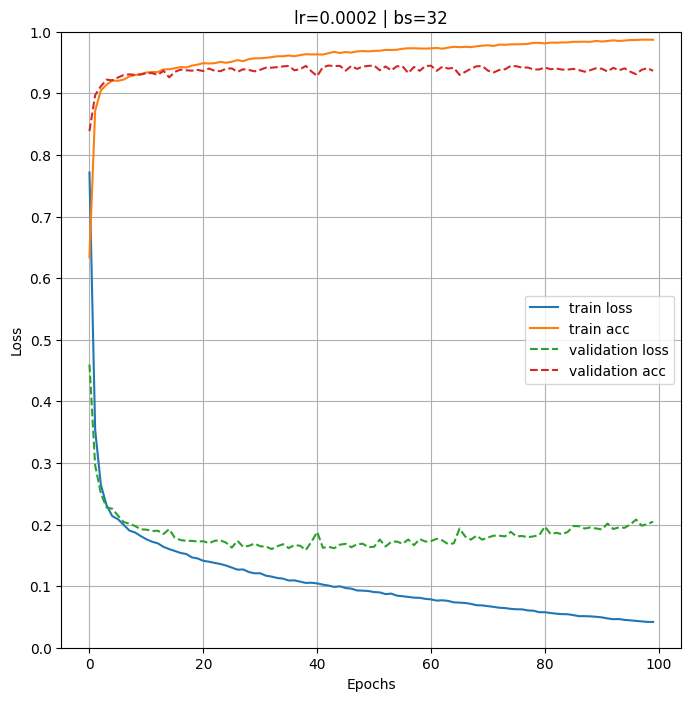

In [11]:
# try with learning rate decay
set_seed(SEED)
num_epochs = 100
model = Conv2Net(k1_size, k2_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_decay = lambda epoch: 0.99**epoch
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_decay)
train_loss, val_loss, train_acc, val_acc, model = train_model(
    model,
    train_dataset,
    val_dataset,
    batch_size,
    num_epochs,
    lr,
    optimizer=optimizer,
    scheduler=lr_scheduler,
)
fig = plot_train_val_loss(
    num_epochs,
    train_loss,
    train_acc,
    val_loss,
    val_acc,
    title=f"lr={lr} | bs={batch_size}",
)

--- Epoch 1/40: 
Train      -> loss = 0.660 | acc = 0.735
Validation -> loss = 0.356 | acc = 0.874
--- Epoch 2/40: 
Train      -> loss = 0.302 | acc = 0.889
Validation -> loss = 0.269 | acc = 0.904
--- Epoch 3/40: 
Train      -> loss = 0.244 | acc = 0.908
Validation -> loss = 0.242 | acc = 0.909
--- Epoch 4/40: 
Train      -> loss = 0.218 | acc = 0.918
Validation -> loss = 0.222 | acc = 0.918
--- Epoch 5/40: 
Train      -> loss = 0.205 | acc = 0.922
Validation -> loss = 0.212 | acc = 0.921
--- Epoch 6/40: 
Train      -> loss = 0.193 | acc = 0.927
Validation -> loss = 0.205 | acc = 0.923
--- Epoch 7/40: 
Train      -> loss = 0.186 | acc = 0.931
Validation -> loss = 0.200 | acc = 0.924
--- Epoch 8/40: 
Train      -> loss = 0.181 | acc = 0.930
Validation -> loss = 0.207 | acc = 0.931
--- Epoch 9/40: 
Train      -> loss = 0.176 | acc = 0.934
Validation -> loss = 0.196 | acc = 0.929
--- Epoch 10/40: 
Train      -> loss = 0.169 | acc = 0.937
Validation -> loss = 0.196 | acc = 0.930
--- Epoch

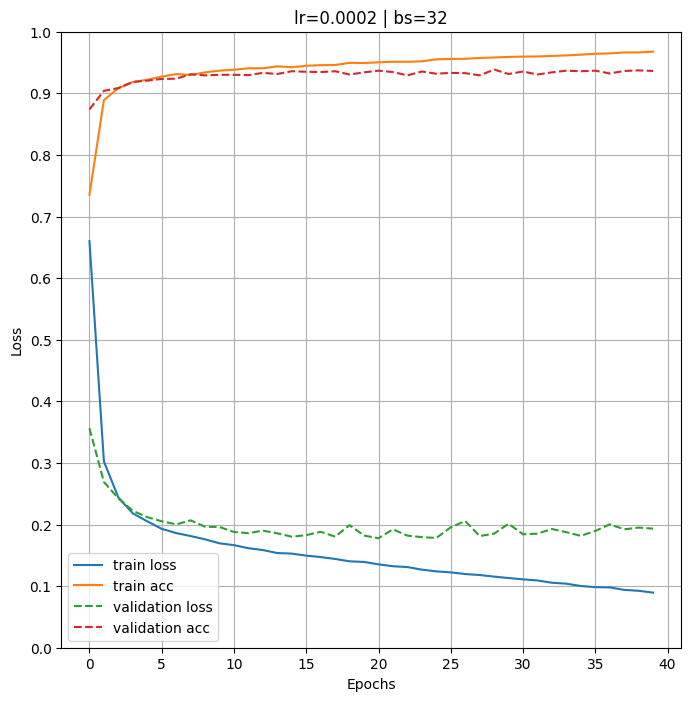

In [17]:
# rectangular kernels?
set_seed(SEED)
k1_size = (3, 5)
k2_size = (3, 5)
model = Conv2Net(k1_size, k2_size)
train_loss, val_loss, train_acc, val_acc, model = train_model(
    model, train_dataset, val_dataset, batch_size, num_epochs, lr
)
fig = plot_train_val_loss(
    num_epochs,
    train_loss,
    train_acc,
    val_loss,
    val_acc,
    title=f"lr={lr} | bs={batch_size}",
)

In [18]:
# Test Data Augmentation on X_train

def augment_data_with_noise(X_train, y_train, noise_power, aug_factor=0.5):
    np.random.seed(SEED)
    map_size = (11, 61)
    n_train = X_train.shape[0]
    n_augmented = int(aug_factor * n_train)
    samples_idx = np.random.choice(n_train, n_augmented, replace=False)
    X_aug = np.zeros((n_train + n_augmented, *map_size))
    y_aug = np.zeros(n_train + n_augmented)
    X_aug[:n_train, :, :] = X_train
    y_aug[:n_train] = y_train
    for i, sid in enumerate(samples_idx):
        X_aug[n_train + i, :, :] = X_train[sid, :, :] + np.sqrt(
            noise_power
        ) * np.random.randn(*map_size)
        y_aug[n_train + i] = y_train[sid]
    return X_aug, y_aug

--- Epoch 1/40: 
Train      -> loss = 0.673 | acc = 0.715
Validation -> loss = 0.375 | acc = 0.858
--- Epoch 2/40: 
Train      -> loss = 0.316 | acc = 0.885
Validation -> loss = 0.268 | acc = 0.911
--- Epoch 3/40: 
Train      -> loss = 0.259 | acc = 0.905
Validation -> loss = 0.246 | acc = 0.917
--- Epoch 4/40: 
Train      -> loss = 0.239 | acc = 0.909
Validation -> loss = 0.230 | acc = 0.921
--- Epoch 5/40: 
Train      -> loss = 0.227 | acc = 0.915
Validation -> loss = 0.220 | acc = 0.922
--- Epoch 6/40: 
Train      -> loss = 0.217 | acc = 0.918
Validation -> loss = 0.211 | acc = 0.923
--- Epoch 7/40: 
Train      -> loss = 0.209 | acc = 0.920
Validation -> loss = 0.211 | acc = 0.924
--- Epoch 8/40: 
Train      -> loss = 0.203 | acc = 0.922
Validation -> loss = 0.199 | acc = 0.930
--- Epoch 9/40: 
Train      -> loss = 0.197 | acc = 0.926
Validation -> loss = 0.193 | acc = 0.932
--- Epoch 10/40: 
Train      -> loss = 0.191 | acc = 0.928
Validation -> loss = 0.193 | acc = 0.931
--- Epoch

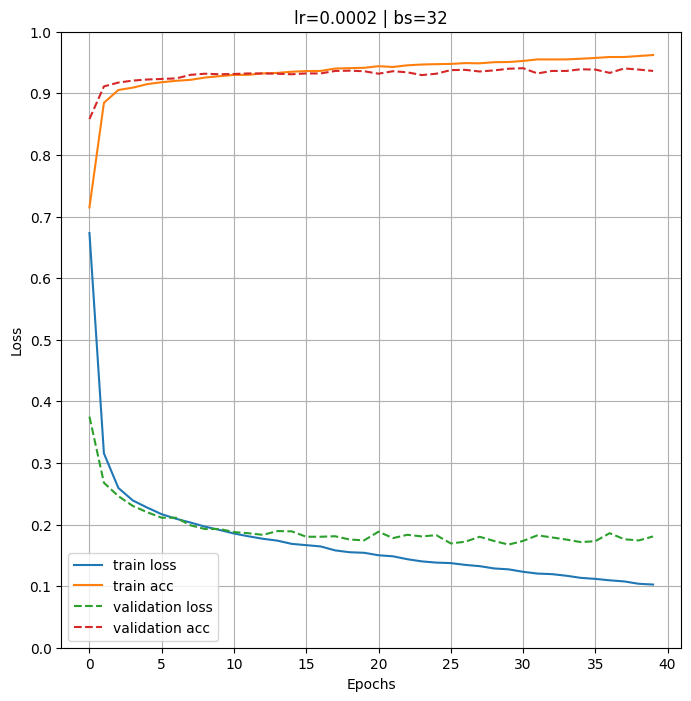

In [19]:
set_seed(SEED)
X_aug, y_aug = augment_data_with_noise(X_train, y_train, noise_power=1, aug_factor=0.5)
train_dataset = MapsDataset(X_aug, y_aug)
k1_size = (3, 3)
k2_size = (3, 3)
model = Conv2Net(k1_size, k2_size)
train_loss, val_loss, train_acc, val_acc, model = train_model(
    model, train_dataset, val_dataset, batch_size, num_epochs, lr
)
fig = plot_train_val_loss(
    num_epochs,
    train_loss,
    train_acc,
    val_loss,
    val_acc,
    title=f"lr={lr} | bs={batch_size}",
)